 # Messages associés dans des données

Ce TP a pour but de mettre en œuvre la paramétrisation de messages par la technique des "sacs de mots" et de regrouper ces messages par l’algorithme des K-moyennes. 
Dans un premier temps vous travaillerez sur des messages  "jouets" que vous aurez choisis pour vous familiariser avec les différentes étapes de la paramétrisation (CountVectorizer puis Stemming et TF-IDF) et  étudier l’évolution de l’algorithme KMeans.

Dans un second temps, vous analyserez les synopsis de 100 films récupérées sur wikipedia et IMDb, afin d'identifier **automatiquement** les thèmes récurrents dans ces films.

Les modules python à utiliser pour ce TP sont numpy, nltk.stem, sklearn.feature_extraction.text, sklearn.cluster et sklearn.datasets.

## Messages "jouets" - Prise en main des outils 

Choisir un corpus (une liste de chaines de caractères) d’une dizaine de messages courts (quelques mots) en français, relatifs à **deux** «thèmes» de votre choix bien distincts. 

In [49]:
corpus=['vous êtes excellents',
        'les étudiants sont souvent excellents',
        'les étudiants aiment bien rigoler',
        'rigoler est excellent pour la santé',
        'étudier est excellent',
        'que la montagne est belle en hiver',
        'en hiver il fait beau mais froid','la neige en montagne est belle',
        'la neige en hiver est pénible',
        'le froid en hiver est pénible'
       ]

### Transformation de documents textuels en vecteurs numériques

Afin d'appliquer les méthodes d'apprentissage automatique, il est nécessaire de convertir les documents textuels en vecteurs numériques. 

On peut faire cela à l'aide de la méthode *fit_transform()* de  la classe *CountVectorizer*.

In [50]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

X = vectorizer.fit_transform(corpus)

L'une des operations effectuées par cette méthode est de construire le **dictionnaire des mots** qui apparaissent dans la totalité du corpus.

In [51]:
M,N=X.shape

print("taille du corpus : ",M)
print("taille du vocabulaire : ",N)
print()
print(vectorizer.vocabulary_)

taille du corpus :  10
taille du vocabulaire :  29

{'vous': 25, 'êtes': 28, 'excellents': 7, 'les': 14, 'étudiants': 26, 'sont': 23, 'souvent': 24, 'aiment': 0, 'bien': 3, 'rigoler': 21, 'est': 5, 'excellent': 6, 'pour': 18, 'la': 12, 'santé': 22, 'étudier': 27, 'que': 20, 'montagne': 16, 'belle': 2, 'en': 4, 'hiver': 10, 'il': 11, 'fait': 8, 'beau': 1, 'mais': 15, 'froid': 9, 'neige': 17, 'pénible': 19, 'le': 13}


Le résultat de la méthode *fit_transform()* est la **matrice des occurrences** des mots, que l'on peut  visualiser par la méthode *toarray()*.

In [52]:
print(X.toarray())

[[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0]
 [1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 1 0 1 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]]


Dans la matrice des occurrences, une ligne corresponde à un document particulier, tandis qu'une colonne corresponde à l'un des mots dans le dictionnaire. 

Par exemple, la première ligne de la matrice est la représentation numérique du premier document du corpus. Remarquez la correspondance directe entre la position des composants non-nuls dans le vecteur et la position des mots dans le dictionnaire !

In [53]:
print("Document du corpus:")
print("<< " +  corpus[0] + " >>")
print()
print( "Représentation numerique:" )
print( X[0].toarray() )
print()
print( "Correspondance entre le vecteur et le dictionnaire:" )
print( (X[0] != 0) )

Document du corpus:
<< vous êtes excellents >>

Représentation numerique:
[[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1]]

Correspondance entre le vecteur et le dictionnaire:
  (0, 7)	True
  (0, 25)	True
  (0, 28)	True


-----

**Un document est donc représenté par un vecteur de la même taille que le dictionnaire, dont la composante i indique le nombre d'occurrences du i-ème mot du dictionnaire dans le document.**

-----

Une fois transformé les documents en vecteurs numériques, ils peuvent être traités comme des points dans un espace euclidien tel que $\mathbb{R}^N$. 

Cela vous permet de calculer la matrice des distances (2 à 2) entre les documents de votre corpus.

In [54]:
import numpy as np
np.set_printoptions(formatter={'float': '{: 0.2f}'.format}) # definit la visualisation des nombres réels

from sklearn.metrics.pairwise import euclidean_distances

# calcule les distances entre les documents
dist_corpus = euclidean_distances(X)


print("Matrice des distances:")
print(dist_corpus)

Matrice des distances:
[[ 0.00  2.45  2.83  3.00  2.45  3.16  3.16  3.00  3.00  3.00]
 [ 2.45  0.00  2.45  3.32  2.83  3.46  3.46  3.32  3.32  3.32]
 [ 2.83  2.45  0.00  3.00  2.83  3.46  3.46  3.32  3.32  3.32]
 [ 3.00  3.32  3.00  0.00  2.24  3.00  3.61  2.83  2.83  3.16]
 [ 2.45  2.83  2.83  2.24  0.00  2.83  3.16  2.65  2.65  2.65]
 [ 3.16  3.46  3.46  3.00  2.83  0.00  3.16  1.73  2.24  2.65]
 [ 3.16  3.46  3.46  3.61  3.16  3.16  0.00  3.32  3.00  2.65]
 [ 3.00  3.32  3.32  2.83  2.65  1.73  3.32  0.00  2.00  2.83]
 [ 3.00  3.32  3.32  2.83  2.65  2.24  3.00  2.00  0.00  2.00]
 [ 3.00  3.32  3.32  3.16  2.65  2.65  2.65  2.83  2.00  0.00]]


La position $(i,j)$ de cette matrice contient la distance euclidienne entre les documents $i$ et $j$ de votre corpus. 

Vous pouvez explorer les similarités dans vos données au travers du *positionnement multidimensionnel (MDS)*, une technique statistique qui perment de visualiser l'information à l'aide d'un graphe 2D ou 3D. Voici les codes python pour visualiser les documents comme des points 2D.

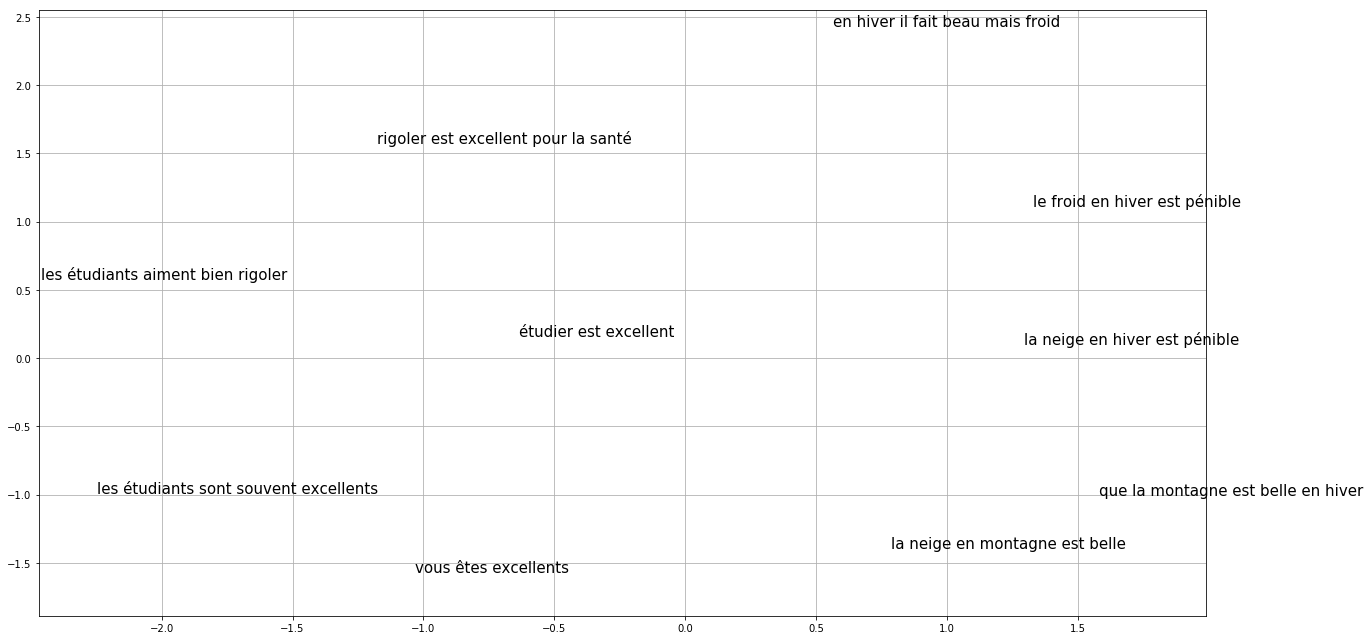

In [55]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# transforme les documents en points 2D.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform( dist_corpus )

# visualise les points
%matplotlib inline
fig, ax = plt.subplots(figsize=(17, 9))
plt.scatter( pos[:,0], pos[:,1],  c='white', marker='o', s=200)
plt.grid()
plt.tight_layout()

# ajoute le début du document à coté de chaque point
for i in range(len(pos)):
    ax.text(pos[i,0]-0.2, pos[i,1]+0.1, corpus[i], size=15)

Dans la figure ci-dessus, un point représente l'un des documents que vous avez rédigé. 

Vous pouvez utiliser des couleurs differentes pour distinguer les deux thèmes sur lesquels portent les documents. 

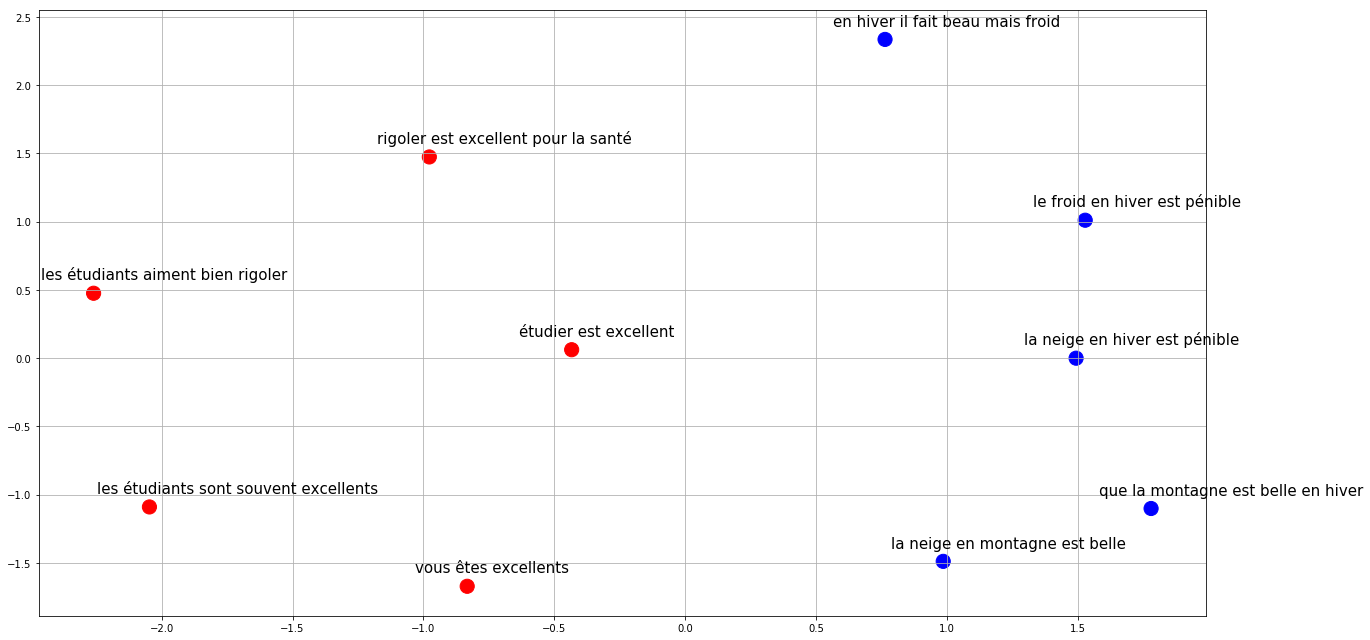

In [56]:
import matplotlib

# indiquez une label pour chaque document (0=premier thème, 1=deuxieme thème)
labels = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]  # TODO : replir ce vecteur en accord avec vos documents

# visualise les points
colors = ['red', 'blue']
fig, ax = plt.subplots(figsize=(17, 9))
plt.scatter( pos[:,0], pos[:,1], s=200, c=labels, cmap=matplotlib.colors.ListedColormap(colors) )
plt.grid()
plt.tight_layout()

# ajoute le début du document à coté de chaque point1
for i in range(len(pos)):
    ax.text(pos[i,0]-0.2, pos[i,1]+0.1, corpus[i], size=15)

---

**Ces points sont-ils regroupés en accord avec vos deux thèmes ?** 

Si les documents que vous avez rédigé portent sur deux thèmes bien identifiés et distincts, la réponse est affirmative ! 

L'idée est que les documents contenant des mots semblables sont *proches*, ce qui refléte des contenus de significations similaires. 

*(Eventuellement, modifier votre corpus pour que ce soit le cas.)*

---

### Classer les documents en deux groupes

La question que nous posons est la suivante :

**Sur la base de l'observation précédente, peut-on regrouper *automatiquement* les documents ayant des contenus de signification similaire ?**

La réponse est affirmative. Pour ce faire, vous pouvez utiliser la méthode *fit_predict()* de la classe *KMeans*. 

In [57]:
from sklearn.cluster import KMeans

# définit les options de classification
#  - n_clusters=2 --> deux clusters
#  - verbose=1    --> affiche l'évolution du critère pour chaque initialisation
clust = KMeans(n_clusters=2, n_init=10, init='k-means++', verbose=1)

# calcule les labels de chaque document du corpus
Ckm = clust.fit_predict(X)

Initialization complete
Iteration  0, inertia 53.000
Iteration  1, inertia 29.524
Converged at iteration 1: center shift 0.000000e+00 within tolerance 1.351724e-05
Initialization complete
Iteration  0, inertia 49.000
Iteration  1, inertia 29.524
Converged at iteration 1: center shift 0.000000e+00 within tolerance 1.351724e-05
Initialization complete
Iteration  0, inertia 55.000
Iteration  1, inertia 28.800
Converged at iteration 1: center shift 0.000000e+00 within tolerance 1.351724e-05
Initialization complete
Iteration  0, inertia 49.000
Iteration  1, inertia 29.524
Converged at iteration 1: center shift 0.000000e+00 within tolerance 1.351724e-05
Initialization complete
Iteration  0, inertia 66.000
Iteration  1, inertia 30.167
Converged at iteration 1: center shift 0.000000e+00 within tolerance 1.351724e-05
Initialization complete
Iteration  0, inertia 68.000
Iteration  1, inertia 30.431
Iteration  2, inertia 28.800
Converged at iteration 2: center shift 0.000000e+00 within tolerance 

Le résultat de cette méthode est un vecteur de labels, où **le label i indique la classe du document i**.

In [58]:

print("Classe des documents:")
print(Ckm)

Classe des documents:
[0 0 0 0 0 1 1 1 1 1]


Vous pouvez visualiser la classification obtenue sur un graphe 2D.

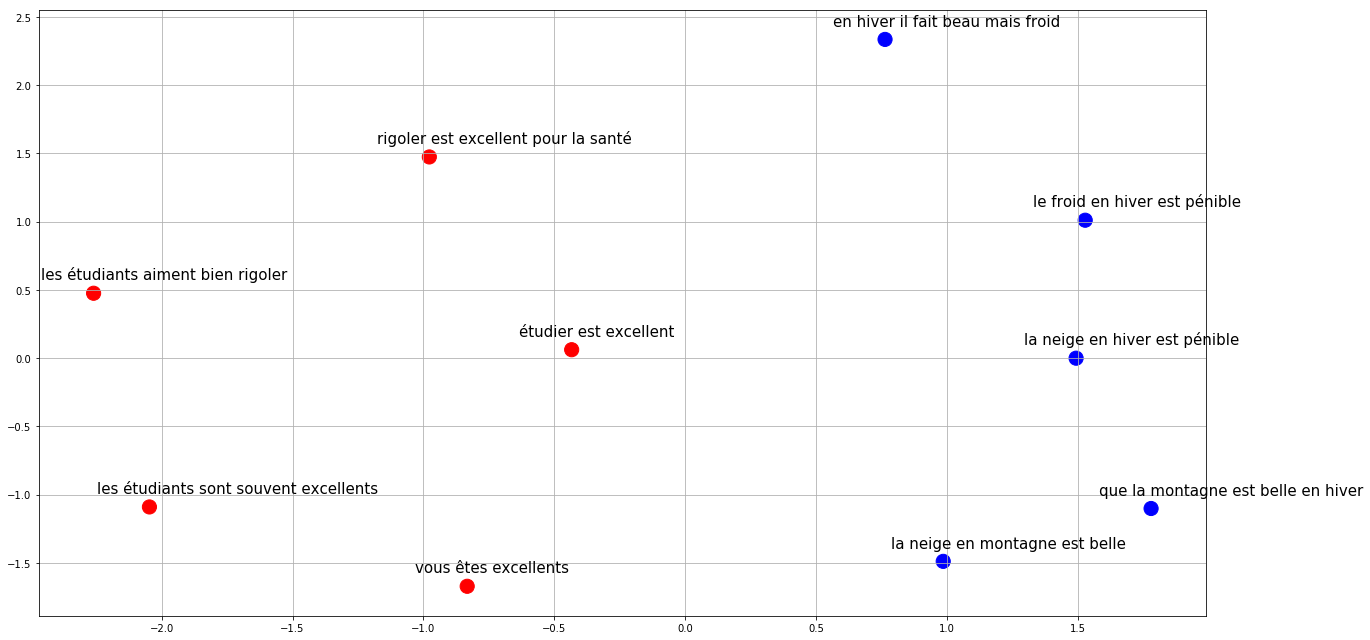

In [59]:
colors = ['red', 'blue']
fig, ax = plt.subplots(figsize=(17, 9))

plt.scatter( pos[:,0], pos[:,1], s=200, c=Ckm, cmap=matplotlib.colors.ListedColormap(colors) )
plt.grid()
plt.tight_layout()

for i in range(len(pos)):
    ax.text(pos[i,0]-0.2, pos[i,1]+0.1, corpus[i], size=15)

---

** Les documents sont-ils classifiés en accord avec vos deux thèmes ? **

---

Pour interpréter les résultats, vous pouvez analyser les *centroides* calculés par l'algorithme K-Means. 

Plus précisément, vous pouvez afficher les *mots clés* associés à chaque centroide.

In [60]:
mots0 = vectorizer.inverse_transform( clust.cluster_centers_[0] )
mots1 = vectorizer.inverse_transform( clust.cluster_centers_[1] )

print("Thème 0:")
print( ' '.join(mots0[0]) )
print()
print("Thème 1:")
print( ' '.join(mots1[0]) )

Thème 0:
aiment bien est excellent excellents la les pour rigoler santé sont souvent vous étudiants étudier êtes

Thème 1:
beau belle en est fait froid hiver il la le mais montagne neige pénible que


Remarquez la présence de *mots inutiles* (est, il, la, ...) et de *mots similaires* (excellent , excellents, ...) parmi les mots clés de chaque thème.

### Réduction de la taille du vocabulaire

Il est raisonnable de ne pas prendre en compte les *stop words*, à savior les mots tels que les articles, les verbes auxilliaires, les conjonctions, les liaisons, et tous les mots très usuels qui n'apportent aucune information sur le sens du document. De plus, pour réduire ultérieurement les redondances, on ne peut que garder la racine des mots au travers d'une opération de *stemming*. 

**Refaites la conversion des documents textuels en vecteurs numériques, cette fois avec le stemming et sans les stop words.**

En premier lieu, redéfinissez la classes *FrenchStemmedCountVectorizer* comme montré dans le cours.

In [65]:
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> l

Packages:
  [*] abc................. Australian Broadcasting Commission 2006
  [*] alpino.............. Alpino Dutch Treebank
  [*] averaged_perceptron_tagger Averaged Perceptron Tagger
  [ ] averaged_perceptron_tagger_ru Averaged Perceptron Tagger (Russian)
  [*] basque_grammars..... Grammars for Basque
  [*] biocreative_ppi..... BioCreAtIvE (Critical Assessment of Information
                           Extraction Systems in Biology)
  [*] bllip_wsj_no_aux.... BLLIP Parser: WSJ Model
  [*] book_grammars....... Grammars from NLTK Book
  [*] brown............... Brown Corpus
  [*] brown_tei........... Brown Corpus (TEI XML Version)
  [*] cess_cat............ CESS-CAT Treebank
  [*] cess_esp............ CESS-ESP Treebank
  [*] chat80.....

True

In [66]:
# définit les "stop words" français
import nltk
import nltk.stem
from nltk.corpus import stopwords
stwf=stopwords.words('french')

# définit le stemmer en français
french_stemmer=nltk.stem.SnowballStemmer('french')
class FrenchStemmedCountVectorizer(CountVectorizer): # hérite de CountVectorizer
    def build_analyzer(self):
        analyzer = super(FrenchStemmedCountVectorizer, self).build_analyzer()
        return lambda doc: (french_stemmer.stemmer.stem(word) for word in analyzer(doc))
        

Ensuite, appelez la méthode *fit_transform()* sur votre corpus de documents.

In [67]:
Fvectorizer = FrenchStemmedCountVectorizer(min_df=1, stop_words=stwf)
X = Fvectorizer.fit_transform(corpus)

Afficher le nouveau dictionnaire des mots.

In [68]:
M,N=X.shape

print("taille du corpus : ",M)
print("taille du vocabulaire : ",N)
print()
print(Fvectorizer.vocabulary_)

taille du corpus :  10
taille du vocabulaire :  16

{'excellent': 4, 'le': 8, 'étudi': 15, 'souvent': 14, 'aiment': 0, 'bien': 3, 'rigol': 12, 'sant': 13, 'montagn': 9, 'bel': 2, 'hiv': 7, 'fait': 5, 'beau': 1, 'froid': 6, 'neig': 10, 'pénibl': 11}


On peut visualizer les documents transformés en utilisant les mots du nouveau dictionnaire.

In [69]:
# recupere les mots du dictionnaire 
new_corpus = Fvectorizer.inverse_transform( X )

# visualise
padding = len( max(corpus, key=len) )
for i in range(M):
    print( "%s ==> %s" % (corpus[i].ljust(padding), ' '.join(new_corpus[i])) )

vous êtes excellents                  ==> excellent
les étudiants sont souvent excellents ==> souvent étudi le excellent
les étudiants aiment bien rigoler     ==> rigol bien aiment étudi le
rigoler est excellent pour la santé   ==> sant rigol excellent
étudier est excellent                 ==> étudi excellent
que la montagne est belle en hiver    ==> hiv bel montagn
en hiver il fait beau mais froid      ==> froid beau fait hiv
la neige en montagne est belle        ==> neig bel montagn
la neige en hiver est pénible         ==> pénibl neig hiv
le froid en hiver est pénible         ==> pénibl froid hiv


Recalculez la matrices des distances et visualisez-la comme montré précédemment.

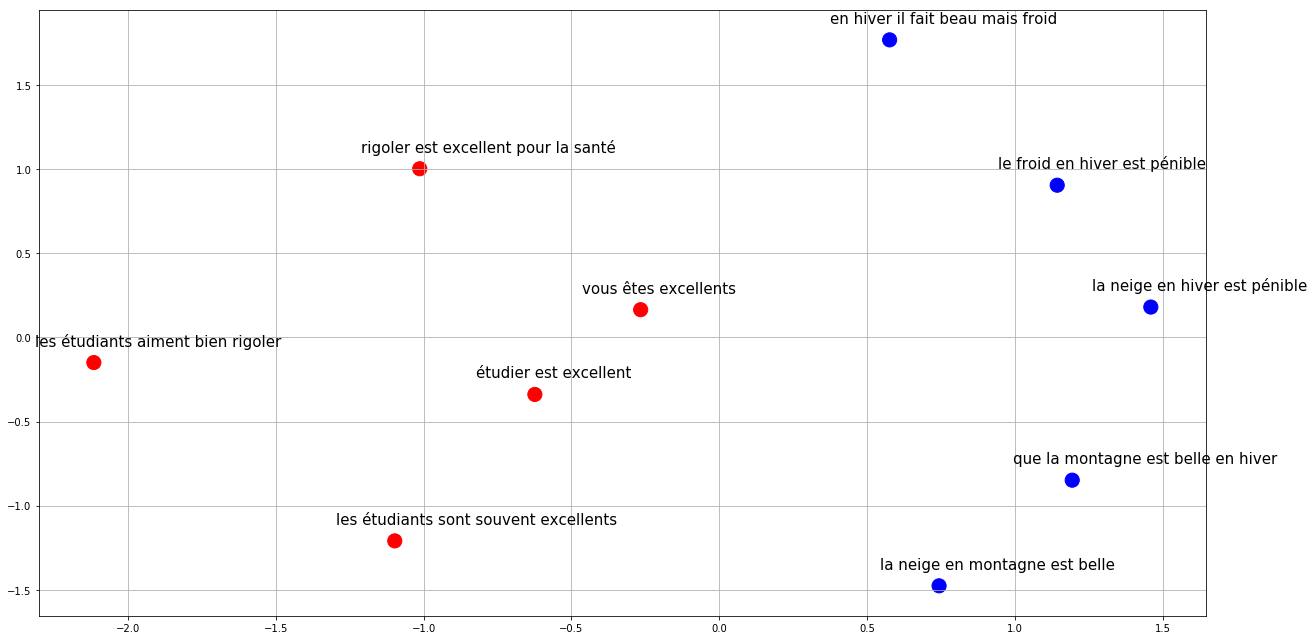

In [70]:
# distance des documents
dist_corpus = euclidean_distances(X)

# transforme les documents en points 2D.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform( dist_corpus )

# visualise les points
colors = ['red', 'blue']
fig, ax = plt.subplots(figsize=(17, 9))
plt.scatter( pos[:,0], pos[:,1], s=200, c=labels, cmap=matplotlib.colors.ListedColormap(colors) )
plt.grid()
plt.tight_layout()

# ajoute le début du document à coté de chaque point
for i in range(len(pos)):
    ax.text(pos[i,0]-0.2, pos[i,1]+0.1, corpus[i], size=15)

Reclassifiez les documents à l'aide de l'algorithme K-Means.

In [ ]:
# définit les options de classification
clust = KMeans(<<ADD CODE HERE>>)

# calcule les labels de chaque document du corpus
Ckm = clust.<<ADD CODE HERE>>

Pour interpréter les résultats, vous pouvez reanalyser les centroides calculés par l'algorithme K-Means.

In [ ]:
mots0 = Fvectorizer.inverse_transform( clust.cluster_centers_[0] )
mots1 = Fvectorizer.inverse_transform( clust.cluster_centers_[1] )

print("Thème 0:")
print( ' '.join(mots0[0]) )
print()
print("Thème 1:")
print( ' '.join(mots1[0]) )

---

**Maintenant, vous devriez avoir une indication plus précise des mots clés associés aux deux thèmes.**

---

## Top 100 Greatest Movies of All Time

Pour montrer l'intérêt de la classification de messages, nous analyseront les synopsis de 100 films (récupérées sur wikipedia et IMDb), afin d'identifier **automatiquement** les thèmes récurrents dans ces films.

Vous trouverez les données textuelles dans les fichiers qui accompagnent le présent notebook.

In [ ]:
# Si beautifulsoup pas installé
# !pip3 install BeautifulSoup4 --user

In [ ]:
from bs4 import BeautifulSoup

# récupère 100 films
titles = open('title_list.txt').read().split('\n')
titles = titles[:100]

# récupère les liens sur IMDb
links = open('link_list_imdb.txt').read().split('\n')
links = links[:100]

# récupère les genres
genres = open('genres_list.txt').read().split('\n')
genres = genres[:100]

# récupère les synopses de wikipedia
synopses_wiki = open('synopses_list_wiki.txt', encoding="utf8").read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

# récupère les synopses de IMDb
synopses_imdb = open('synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]

# nettoie les synopses de wikipedia
synopses_clean_wiki = []
for text in synopses_wiki:
    text = BeautifulSoup(text, 'html.parser').getText()
    synopses_clean_wiki.append(text)
synopses_wiki = synopses_clean_wiki

# nettoie les synopses de IMDb
synopses_clean_imdb = []
for text in synopses_imdb:
    text = BeautifulSoup(text, 'html.parser').getText()
    synopses_clean_imdb.append(text)
synopses_imdb = synopses_clean_imdb

# fusionne les deux synopses
synopses = []
for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)
    
# génère les indices pour chaque élément dans le corpus
ranks = []
for i in range(0,len(titles)):
    ranks.append(i)

Voici les données relatives à quelque film.

In [ ]:
idx = 0; # changer l'indice pour afficher un film different

print( titles[idx] )
print()
print( links[idx] )
print()
print( genres[idx] )
print()
print( synopses[idx][1:500] )

### Etape 1 : Transformation TF-IDF

La première étape consiste à convertir les documents textuels en vecteur numériques. Pour ce faire, vous utiliserez la transformation TF-IDF vue en cours.

La classe *TfidfVectorizer* permet obtenir des vecteurs de composantes tf-idf. Il est cependant nécessaire, si l'on veut reduire le dictionnaire avant de construire les vecteurs tf-idf, de créer une nouvelle classe *StemmedTfidfVectorizer*, comme vous l'avez fait précédemment pour *StemmedCountVectorizer*.

In [ ]:
<<ADD CODE HERE>>

Appelez la méthode *fit_transform()* sur les synopsis.

In [ ]:
<<ADD CODE HERE>>

Afficher les informations sur le dictionnaire des mots. Remarquez la taille de celui-ci sur une application réelle !

In [ ]:
<<ADD CODE HERE>>

Calculez la matrice des distances et afficher le résultat dans un graphe 2D (comme montré dans l'exemple precedent).

In [ ]:
<<ADD CODE HERE>>

L'indice de chaque point vous permet de recuperer le titre correspondant.

In [ ]:
idx = 9 

print("Titre du film n°", idx, ": " + titles[9] )

---

**Vous pouvez modifier les paramètres *min_df* et *max_df* dans la fonction *StemmedTfidfVectorizer()*, afin de changer la taille du dictionnaire. L'impact de ce changement sera visible sur la figure ci-dessus.**

---

### Etape 2 : Clustering

La deuxieme étape consiste à regrouper les films en utilisant l'algorithme *K-Means* vu en cours.

Vous avez le choix sur un paramètre : le **nombre de thèmes** dont les films seront regroupés.

In [ ]:
<<ADD CODE HERE>>

Vous pouvez visualiser la classification obtenue sur un graphe 2D.

In [ ]:
import matplotlib
import matplotlib.pyplot as plt


colors = ['pink', 'lightblue', 'lightgreen', 'orange', 'yellow', 'red', 'green', 'blue', 'cyan', 'brown']

fig, ax = plt.subplots(figsize=(25, 15))
plt.scatter( pos[:,0], pos[:,1], s=300, c=Ckm, cmap=matplotlib.colors.ListedColormap(colors) )
plt.grid()
plt.tight_layout()

for i in range(len(pos)):
    ax.text(pos[i,0]+0.01, pos[i,1]+0.01, ranks[i], size=25)

Vouz pouvez analyser les résultats de plusieurs points de vue. 

- Afficher l'histogrammme des labels obtenus

In [ ]:
<<ADD CODE HERE>>

 - Visualizer les mots clés de chaque thème

In [ ]:
<<ADD CODE HERE>>